In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input 
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Add, DepthwiseConv2D, Flatten
from tensorflow.keras.models import Model

plt.rcParams['font.size'] = 16

In [3]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    conv_1x1 = Conv2D(filters_1x1, kernel_size=(1,1), padding='same', activation='relu')(x)
    
    preconv_3x3 = Conv2D(filters_3x3_reduce, kernel_size=(1,1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, kernel_size=(3,3), padding='same', activation='relu')(preconv_3x3)
    
    preconv_5x5 = Conv2D(filters_5x5_reduce, kernel_size=(1,1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, kernel_size=(5,5), padding='same', activation='relu')(preconv_5x5)
    
    pool_proj = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, kernel_size=(1,1), padding='same', activation='relu')(pool_proj)
    
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [4]:
def residual_block(x, kernel_size, filters, s=2):
    f1,f2,f3 = filters
    x_shortcut = x
    
    # Shortcut Path
    x_shortcut = Conv2D(f3, kernel_size=(1,1), strides=(s,s), padding='valid')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    
    # Main Path
    # First Component
    x = Conv2D(f1, kernel_size=(1,1), strides=(s,s), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second Component
    x = Conv2D(f2, kernel_size=kernel_size, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Third Component
    x = Conv2D(f3, kernel_size=(1,1), strides=(1,1), padding='valid')(x)
    x = BatchNormalization()(x)
    
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)
    
    return x

In [5]:
def mobilenet_block(x, kernel_size, filters, strides):
    x = DepthwiseConv2D(kernel_size=(kernel_size,kernel_size), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, kernel_size=(1,1), strides=1, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

**Q2**

In [7]:
input_layer= Input(shape=(227,227,3))
x = Conv2D(32,kernel_size=(7,7), strides= 1, padding='same',activation='relu')(input_layer)
x = MaxPooling2D((3,3),padding='same',strides=(2,2))(x)
x = inception_module(x,64,96,128,16,32,32,name='Inception_1')
x = inception_module(x,64,96,128,16,32,32,name='Inception_2')
x = residual_block(x,(3,3),[64,64,128],1)
x = residual_block(x,(3,3),[64,64,128],1)
x = Flatten()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
output = Dense(10,activation='softmax')(x)
model=Model(inputs=input_layer,outputs=output)


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 227, 227, 32  4736        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 114, 114, 32  0          ['conv2d_21[0][0]']              
                                )                                                             

**Q4**

In [9]:
input_layer= Input(shape=(227,227,3))
x = Conv2D(32,kernel_size=(3,3), strides= (2,2), padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = mobilenet_block(x,3,64,strides=1)
x = mobilenet_block(x,3,64,strides=1)

x = inception_module(x,160,112,224,24,64,64,name='Inception_1')
x = inception_module(x,128,128,256,24,64,64,name='Inception_2')

aux_avg = GlobalAveragePooling2D()(x)
aux_drop = Dropout(0.4)(aux_avg)
aux_output = Dense(10,activation='softmax')(aux_drop)

x = inception_module(x,256,160,320,32,128,128,name='Inception_3')
x = inception_module(x,384,192,384,48,128,128,name='Inception_4')

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

output = Dense(10,activation='softmax')(x)


model=Model(inputs=input_layer,outputs=[aux_output,output])

In [10]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 114, 114, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 114, 114, 32  128        ['conv2d_42[0][0]']              
 ormalization)                  )                                                           

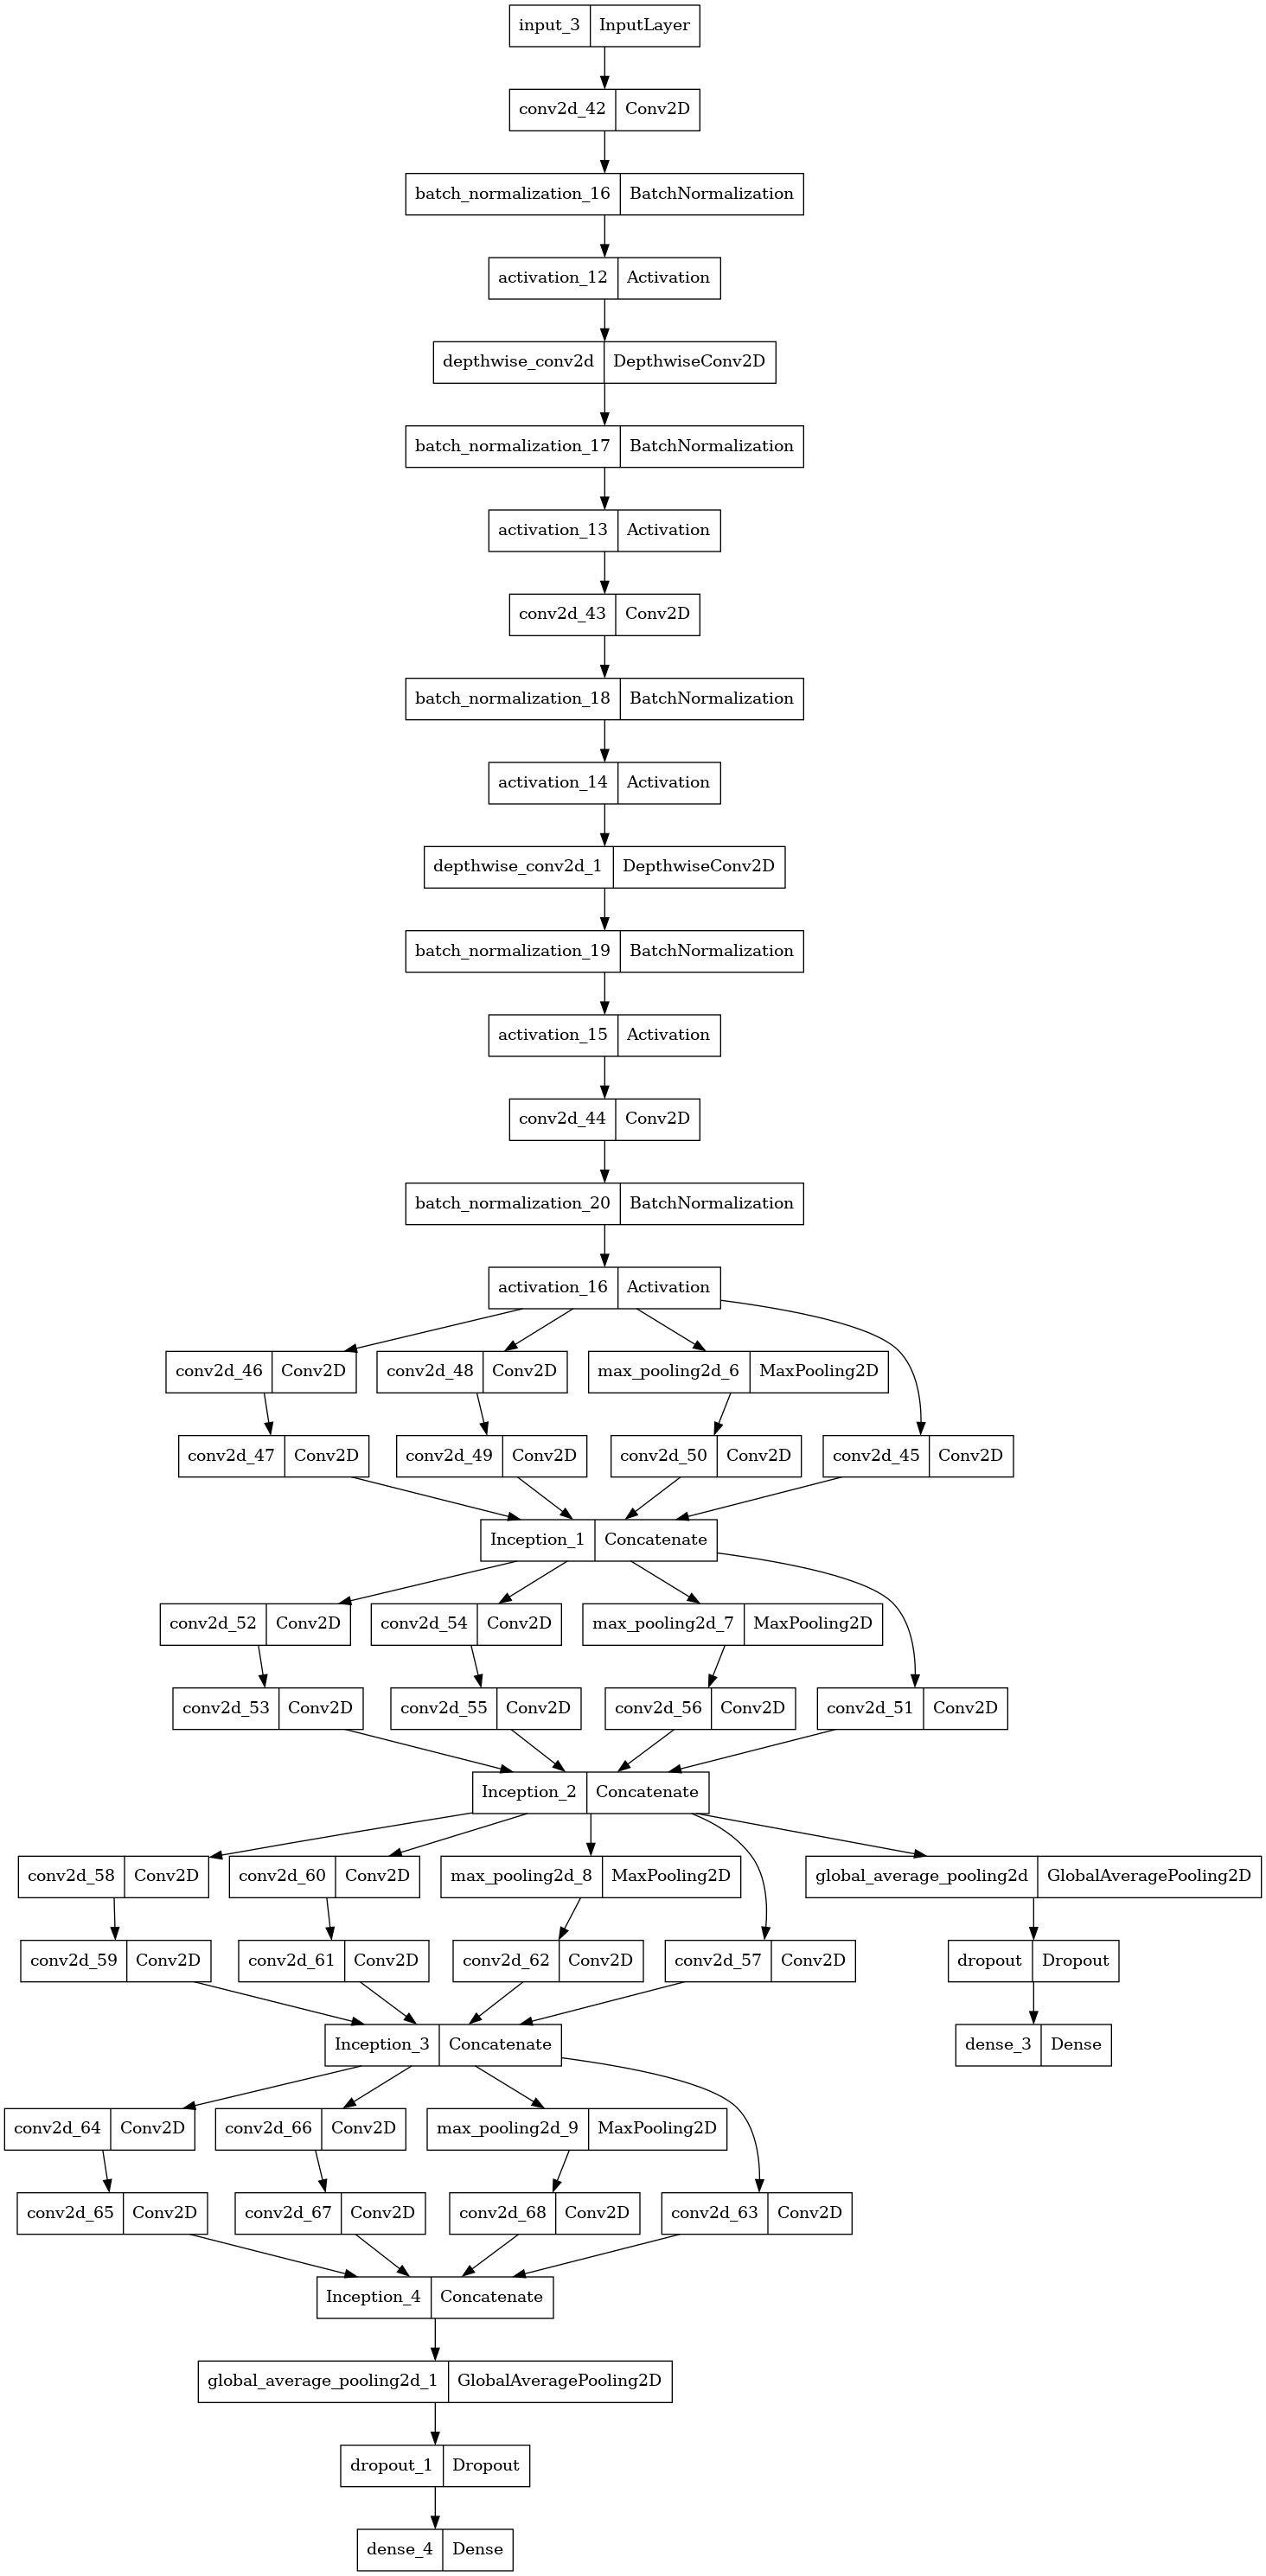

In [11]:
tf.keras.utils.plot_model(model)

**Q1**

In [12]:
input_layer= Input(shape=(224,224,3))
x = Conv2D(32,kernel_size=(11,11), strides= 2, padding='same',activation='relu')(input_layer)
x = MaxPooling2D((3,3),padding='same',strides=(2,2))(x)
x = inception_module(x,64,96,128,16,32,32,name='Inception_1')
x = inception_module(x,364,192,364,48,128,128,name='Inception_2')
x = GlobalAveragePooling2D()(x)
output = Dense(10,activation='softmax')(x)
model=Model(inputs=input_layer,outputs=output)

In [13]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_69 (Conv2D)             (None, 112, 112, 32  11648       ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 56, 56, 32)  0           ['conv2d_69[0][0]']              
 )                                                                                          

**Q3**

In [14]:
input_layer= Input(shape=(227,227,3))
x = Conv2D(32,kernel_size=(7,7), strides= 1, padding='same',activation='relu')(input_layer)
x = MaxPooling2D((3,3),padding='same',strides=(2,2))(x)
x = residual_block(x,(3,3),[64,64,128],1)
x = residual_block(x,(3,3),[64,64,128],1)
x = inception_module(x,64,96,128,16,32,32,name='Inception_1')
x = inception_module(x,64,96,128,16,32,32,name='Inception_2')
x = Flatten()(x)
x = Dense(512,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
output = Dense(10,activation='softmax')(x)
model=Model(inputs=input_layer,outputs=output)

In [15]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_82 (Conv2D)             (None, 227, 227, 32  4736        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 114, 114, 32  0          ['conv2d_82[0][0]']              
 )                              )                                                           

**Q2** - manual CNN arch

In [6]:
input_layer= Input(shape=(150,150,3))
x = Conv2D(25,kernel_size=(3,3), strides= 2)(input_layer)
x = MaxPooling2D((2,2),strides=(2,2))(x)
x = Conv2D(35,kernel_size=(3,3), strides= 2)(x)
x = MaxPooling2D((2,2),strides=(2,2))(x)
x = Conv2D(50,kernel_size=(3,3), strides= 1)(x)
x = MaxPooling2D((2,2),strides=(2,2))(x)

x = Flatten()(x)
x = Dense(1024)(x)

output = Dense(100)(x)
model=Model(inputs=input_layer,outputs=output)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 74, 74, 25)        700       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 25)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 35)        7910      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 35)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 50)          15800 

**Q3** - manual CNN arch

In [8]:
input_layer= Input(shape=(224,224,3))
x = Conv2D(32,kernel_size=(7,7), strides= 4)(input_layer)
x = MaxPooling2D((3,3),strides=(2,2))(x)
x = Conv2D(64,kernel_size=(3,3), strides= 1)(x)
x = MaxPooling2D((3,3),strides=(2,2))(x)
x = Conv2D(128,kernel_size=(3,3), strides= 1)(x)
x = MaxPooling2D((3,3),strides=(2,2))(x)

x = Flatten()(x)
x = Dense(512)(x)

output = Dense(100)(x)
model=Model(inputs=input_layer,outputs=output)

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 32)        4736      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 128)       7385